# **Mecanismo de Auto-atenção para Análise de Sentimento Usando o Dataset IMDB**

#### **Professores:** Roberto A. Lotufo e Rodrigo F. Nogueira
#### **Aluno:** Guilherme Rosa

### **1. Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import gensim
import gensim.downloader as api

import itertools
import collections
import re
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

Usando: cuda


### **2. Preparação dos dados**

#### **2.1. Download do dataset com amostras de treinamento e validação**

In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-10-16 17:34:53--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.2.19, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/imdb_sample.tgz [following]
--2020-10-16 17:34:53--  https://files.fast.ai/data/examples/imdb_sample.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  3.50MB/s    in 0.2s    

2020-10-16 17:34:53 (3.50 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



#### **2.2. Tratamento dos dados**

Carregando o dataset do arquivo .csv com o Pandas:

In [ ]:
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Separação das amostras em conjuntos de treinamento e validação:

In [ ]:
train = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]

print('treino.shape:', train.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


Separação das entradas x e os targets y para treinamento do modelo

In [ ]:
X_train = train['text']
Y_train_str = train['label']
X_valid = valid['text']
Y_valid_str = valid['label']

print('X_treino.head():\n', X_train.head())
print('Y_treino.head():\n', Y_train_str.head())

X_treino.head():
 0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object
Y_treino.head():
 0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object


Conversão das strings "positive" e "negative" dos targets para valores booleanos True e False:

In [ ]:
mapeamento = {'positive': True, 'negative': False}
Y_train = Y_train_str.map(mapeamento)
Y_valid = Y_valid_str.map(mapeamento)
print(Y_train.head())

0    False
1     True
2    False
3     True
4    False
Name: label, dtype: bool


In [ ]:
type(Y_train)

pandas.core.series.Series

### **3. Word embeddings e vocabulário**

#### **3.1. Download dos word embeddings**

Lista dos modelos disponíveis: https://github.com/RaRe-Technologies/gensim-data#models

In [ ]:
word2vec_model = api.load("glove-wiki-gigaword-300")

print(word2vec_model.vectors.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 300)


#### **3.2. Criando o vocabulário**

O vocabulário vai conter as 400000 palavras nas quais o word2vec foi desenvolvido.

Além disso, incluímos um PAD token [PAD] para preencher com id = 400000 as sequências que possuem um número de tokens menor do que o número de tokens nos quais as sequências são truncadas.


In [ ]:
vocab = {word: index for index, word in enumerate(word2vec_model.index2word)}
vocab['[PAD]'] = len(vocab)

print('Número de palavras no vocabulário:', len(vocab))
print(f'20 tokens mais frequentes: {list(itertools.islice(vocab.keys(), 20))}')

Número de palavras no vocabulário: 400001
20 tokens mais frequentes: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


#### **3.3. Alterando a matriz do word2vec**
Na definição da rede neural (seção 5.1) utilizaremos a camada de Embedding do Pytorch.

Para que essa camada funcione corretamente é necessário que a matriz de embedding do word2vec tenha uma linha correspondente ao id do PAD token.

In [ ]:
embedding_pad = np.zeros(shape=(1, word2vec_model.vectors.shape[1]))
word2vec_vectors = np.append(word2vec_model.vectors, embedding_pad, axis=0)

print(word2vec_vectors.shape)

(400001, 300)


### **4. Funções de tokenização e truncamento**

#### **4.1. Funções de tokenização e de conversão para ids**

In [ ]:
def tokenize(text):
    """ Entrada: frase dada numa variável do tipo string
        -------
        Saída  : lista de tokens
    """
    # \w retorna todos os caracteres alfanuméricos e underscore
    # \w+ retorna todas as palavras que contém caracteres alfanuméricos e underscore 
    return re.findall(r'\w+', text.lower())

def tokens_to_ids(tokens, vocab):
    """ Entrada: lista de tokens e um dicionário com pares token: id
        -------
        Saída  : lista de ids
    """
    # Se o token não corresponde a nenhuma palavra do vocabulário, ele é desconsiderado.
    return [vocab[token] for token in tokens if token in vocab]

def tokens_to_ids_batch(texts, vocab):
    """ Entrada: lista de frases
        -------
        Saída  : lista de listas de ids (cada lista de ids corresponde a uma frase da listas de frase de entrada)
    """
    return [tokens_to_ids(tokenize(text), vocab) for text in texts]
        

X_train_ids = tokens_to_ids_batch(X_train, vocab)
X_valid_ids = tokens_to_ids_batch(X_valid, vocab)

print('Primeiro exemplo:')
print(X_train[0])
print(X_train_ids[0])
print(f'Número de tokens da sequência: {len(X_train_ids[0])}')
print(Y_train[0])

Primeiro exemplo:
Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!
[750, 101686, 27886, 18719, 3512, 66019, 2159, 151, 662, 71, 3518, 86321, 31906, 1496, 6, 37, 42, 3520, 907, 285, 13339, 71, 8966, 170723, 2050, 109384, 605, 4, 733, 67, 15, 0, 1938, 13, 37, 2926, 2258, 2844, 24126, 102, 921, 3, 1523, 1305, 31, 26, 432, 51, 13, 79155, 83993, 1229, 37, 15, 1681, 21, 0, 1856, 38, 119, 365, 13247, 390, 30, 7, 11962, 3, 65613, 2290, 1135]
Número de tokens da sequência: 70
False


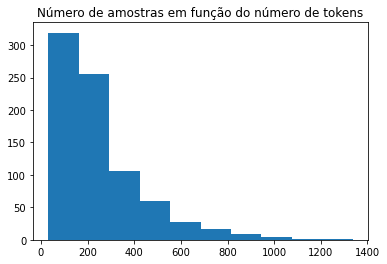

In [ ]:
num_tokens = [len(X_train_id) for X_train_id in X_train_ids]
_ = plt.hist(num_tokens)
plt.title('Número de amostras em função do número de tokens');

Nota-se no histograma acima que a maior parcela das amostras possuem um número de tokens menor do que 400.

#### **4.2. Função para truncamento e padding**

In [ ]:
def truncate_and_pad(batch_word_ids, 
                     pad_token_id=400000, 
                     seq_length=64):
    """ Padroniza as listas de ids do batch de entrada para que todas tenham o mesmo número de elementos (seq_length).
        
        Entrada: listas de listas de ids
        -------
        Saídas : numpy arrays dos ids e das masks 
    """
    # Parte 1: Se o nº de ids > seq_length -> retorna os primeiros seq_length ids (os demais são descartados)
    #          Se o nº de ids < seq_length -> não modifica a lista de ids
    batch_word_ids = [word_ids[:seq_length] if len(word_ids) > seq_length else word_ids for word_ids in batch_word_ids]
    
    # Parte 2: Se o nº de ids > seq_length -> não modifica a lista de ids
    #          Se o nº de ids < seq_length -> cria uma lista com o número de PAD ids necessários para completar o tamanho da lista
    #                                         e concatena ela ao final da lista de ids
    batch_word_ids = [word_ids + [pad_token_id for i in range(seq_length - len(word_ids))] if len(word_ids) < seq_length else word_ids for word_ids in batch_word_ids]
    batch_word_ids = np.array(batch_word_ids)
    
    # Parte 3: Cria a mask utilizada na função softmax
    mask = batch_word_ids != pad_token_id

    return batch_word_ids, mask

# Testing
texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, 
                                     vocab)
print(batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids, 
                               pad_token_id=vocab['[PAD]'],
                               seq_length=8)

print('batch:\n', batch)
print('mask:\n', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)

[[53, 117, 9388], [18, 260, 36, 117, 13134]]
batch:
 [[    53    117   9388 400000 400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000]]
mask:
 [[ True  True  True False False False False False]
 [ True  True  True  True  True False False False]]
batch.shape: (2, 8)
mask.shape: (2, 8)


### **5. Definição da rede neural com self-attention**


#### **5.1. Definição do modelo SelfAttentionNN**

In [ ]:
class SelfAttentionNN(nn.Module):
    def __init__(self, embeddings, hidden_dim, pad_token_id):
        super().__init__()

        self.embeddings_vec = embeddings
        self.hidden_dim = hidden_dim
        self.pad_token_id = pad_token_id
        
        # Word2vec:
        self.embeddings = nn.Embedding.from_pretrained(torch.from_numpy(self.embeddings_vec), freeze=True, padding_idx=self.pad_token_id)
        
        # Classificador binário:
        self.linear = nn.Linear(in_features=self.embeddings_vec.shape[1], out_features=self.hidden_dim)
        self.output = nn.Linear(in_features=self.hidden_dim, out_features=2)
        
    def self_attention(self, q, k, v, mask):
        scores = torch.bmm(q, torch.transpose(k, 2, 1))
        mask = torch.transpose(mask.unsqueeze(dim=2), 2, 1)
        scores = scores.masked_fill(mask == False, -1e9)    # outra forma: mask = mask.expand_as(scores) -> scores[~mask] = -1e9
        probs = torch.softmax(scores, dim=-1)
        E_batch = torch.bmm(probs, v)
        return E_batch

    def forward(self, word_ids, mask):
        X_emb = self.embeddings(word_ids) # Batch de embeddings
        q, k, v = X_emb, X_emb, X_emb
        X_emb = self.self_attention(q=q, k=k, v=v, mask=mask) # Calcula as novas representações para os embeddings do batch
        X_emb = (X_emb * mask.unsqueeze(2)).sum(1) / torch.clamp(mask.sum(1), min=1).unsqueeze(1)  # Calcula a média dos embeddings por amostra do
        hidden = torch.relu(self.linear(X_emb.float()))
        logits = self.output(hidden)
        return logits

    def self_attention_loop(self, seqs, masks):
        batch = [] # armazena as sequências do batch com as novas representações
        for seq, mask in zip(seqs, masks):  
            new_qs = []   # armazena as novas representações para cada sequência do batch
            for q in seq:
                scores = []  # armazena os scores correspondentes a uma query da sequência
                for k, m in zip(seq, mask):
                    if m:
                        score = torch.sum(q * k)  # produto escalar
                    else:
                        score = -1e9   # Aplicação da mascara 
                    scores.append(score)
                scores = torch.softmax(torch.from_numpy(np.array(scores)), dim=0) # aplica a softmax
                
                new_q = torch.zeros_like(q) 
                for v, score in zip(seq, scores):
                    new_q += score * v
                new_qs.append(new_q)
            
            new_qs = torch.stack(new_qs, dim=0)    
            batch.append(new_qs)
        
        batch = torch.stack(batch, dim=0)
        return batch

#### **5.2. Verificando o funcionamento do self-attention com loops e o eficiente - Parte 1**

In [ ]:
texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, 
                                     vocab)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids, 
                               pad_token_id=vocab['[PAD]'],
                               seq_length=8)

model = SelfAttentionNN(embeddings=word2vec_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]'])
seqs_ids = torch.from_numpy(batch)
mask = torch.from_numpy(mask)

seq_embeddings = model.embeddings(seqs_ids)
print(seq_embeddings.shape)
print(mask.shape)

new_seqs1 = model.self_attention_loop(seq_embeddings, mask)
new_seqs2 = model.self_attention(q=seq_embeddings, k=seq_embeddings, v=seq_embeddings, mask=mask)

print(new_seqs1.shape)
print(new_seqs2.shape)
if torch.allclose(new_seqs1, new_seqs2):
    print('Ambas as funções chegaram aos mesmos resultados.')
else:
    print('Os resultados deram diferentes.')

#### **5.3. Verificando o funcionamento do self-attention com loops e o eficiente - Parte 2**

In [ ]:
model = SelfAttentionNN(embeddings=word2vec_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]'])


batch, mask = truncate_and_pad(batch_word_ids=X_train_ids[:32], 
                               pad_token_id=vocab['[PAD]'],
                               seq_length=200)
seqs_ids = torch.from_numpy(batch)
mask = torch.from_numpy(mask)

seq_embeddings = model.embeddings(seqs_ids)
print(seq_embeddings.shape)
print(mask.shape)

new_seqs1 = model.self_attention_loop(seq_embeddings, mask)
new_seqs2 = model.self_attention(q=seq_embeddings, k=seq_embeddings, v=seq_embeddings, mask=mask)

print(new_seqs1.shape)
print(new_seqs2.shape)
if torch.allclose(new_seqs1, new_seqs2):
    print('Ambas as funções chegaram aos mesmos resultados.')
else:
    print('Os resultados deram diferentes.')

torch.Size([32, 200, 300])
torch.Size([32, 200])
torch.Size([2, 8, 300])
torch.Size([32, 200, 300])


### **6. Funções auxiliares**


#### **6.1. Função para retornar mini-batch**

Durante o treinamento de uma rede neural, ao ínves de ajustarmos seus pesos usando todo o dataset de treinamento de uma só vez, é comum usarmos mini-batches, que são apenas algums exemplos amostrados do conjunto de dados. Repetimos isso diversas vezes até termos usado todo o conjunto de treinamento.

Para isso precisamos criar uma função que retorna mini-batches. A função abaixo retorna uma lista de listas contento os índices dos exemplos que serão usados em cada mini-batch. Por exemplo, se o dataset contém 6 amostras e o batch size é 2, a função retorna uma lista contendo 3 listas, cada uma contendo 2 índices: `[[4, 2], [3, 5], [0, 1]]`


In [ ]:
def get_minibatches_idx(total_size, batch_size, shuffle):
    idx_list = np.arange(total_size, dtype=np.int32)
    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(len(idx_list) // batch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + batch_size])
        minibatch_start += batch_size

    if (minibatch_start != len(idx_list)):
        # Fazemos um minibatch do que restou.
        minibatches.append(idx_list[minibatch_start:])

    return minibatches

#### **6.2. Função de treinamento**

In [ ]:
@torch.enable_grad()
def train(X, Y, model, optimizer, criterion, seqlen):
    minibatches = get_minibatches_idx(total_size=len(X), batch_size=16, shuffle=True)

    running_loss = 0
    running_score = 0
    model.train()
    for minibatch_idxs in minibatches:
        # Retorna as listas de índices e os respectivos targets para o mini-batch:
        X_batch = [X[minibatch_idx] for minibatch_idx in minibatch_idxs]
        Y_batch = Y[minibatch_idxs]

        # Faz a padronização do tamanho das sequências de entrada do modelo:
        X_batch, mask = truncate_and_pad(X_batch, seq_length=seqlen, pad_token_id=vocab['[PAD]'])
        
        # Conversão para tensores:
        X_batch = torch.from_numpy(np.array(X_batch, dtype=np.int64)).to(device)
        mask = torch.from_numpy(np.array(mask)).to(device)
        Y_batch = torch.from_numpy(Y_batch).to(device)

        logits = model(word_ids=X_batch, mask=mask)   # Etapa forward
        loss = criterion(logits, Y_batch)             # Cálculo da função custo
        running_loss += loss                          # Custo acumulado
        optimizer.zero_grad()
        loss.backward()                               # Etapa backward (cálculo do gradiente)
        optimizer.step()                              # Ajuste dos pesos sinápticos do modelo e parâmetros do otimizador
        
        class_predictons = logits.argmax(dim=1)                # Predições do modelo para as amostras do mini-batch
        running_score += (class_predictons == Y_batch).sum()   # Soma o número de predições corretas para o mini-batch

    epoch_loss = running_loss.item() / len(minibatches)      # Custo médio da época
    epoch_score = running_score.item() / len(X)              # Número de acertos da época
    return epoch_loss,epoch_score

#### **6.3. Função de validação**

In [ ]:
@torch.no_grad()
def evaluate(X, Y, model, criterion, seqlen):
    minibatches = get_minibatches_idx(total_size=len(X), batch_size=32, shuffle=False)
    
    running_loss = 0
    running_score = 0
    model.eval()
    for minibatch_idxs in minibatches:
        # Retorna as listas de índices e os respectivos targets para o mini-batch:
        X_batch = [X[minibatch_idx] for minibatch_idx in minibatch_idxs]
        Y_batch = Y[minibatch_idxs]

        # Faz a padronização do tamanho das sequências de entrada do modelo:
        X_batch, mask = truncate_and_pad(X_batch, seq_length=seqlen, pad_token_id=vocab['[PAD]'])

        # Conversão para tensores:
        X_batch = torch.from_numpy(np.array(X_batch, dtype=np.int64)).to(device)
        mask = torch.from_numpy(np.array(mask)).to(device)
        Y_batch = torch.from_numpy(Y_batch).to(device)

        logits = model(word_ids=X_batch, mask=mask)            # Etapa forward
        loss = criterion(logits, Y_batch)                      # Cálculo da função custo
        running_loss += loss                                   # Custo acumulado
        
        class_predictons = logits.argmax(dim=1)                # Predições do modelo para as amostras do mini-batch
        running_score += (class_predictons == Y_batch).sum()   # Soma o número de predições corretas para o mini-batch

    epoch_loss = running_loss.item() / len(minibatches)         # Custo médio da época
    epoch_score = running_score.item() / len(X)                 # Número de acertos da época
    return epoch_loss, epoch_score

#### **6.4. Função para plotar o gráficos da função custo:**

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, num):
    plt.figure(num)
    plt.plot(train_metric, label='Training '+ metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.title(metric_name.title() + ' vs Epochs')
    plt.legend(frameon=False)

    return

### **7. Treinamento do modelo**

In [ ]:
N_EPOCHS = 500

model = SelfAttentionNN(embeddings=word2vec_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]']).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

if not isinstance(Y_train, np.ndarray):
    Y_train = Y_train.to_numpy().astype(np.int64)
    Y_valid = Y_valid.to_numpy().astype(np.int64)

train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(X=X_train_ids, Y=Y_train, model=model, optimizer=optimizer, criterion=criterion, seqlen=200)
    valid_loss, valid_acc = evaluate(X=X_valid_ids, Y=Y_valid, model=model, criterion=criterion, seqlen=200)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'epoch: {epoch} '
          f'Train loss: {train_loss:.3f} '
          f'Train accuracy: {train_acc:.3f} '
          f'Valid loss: {valid_loss:.3f} '
          f'Valid accuracy: {valid_acc:.3f}')

epoch: 0 Train loss: 0.692 Train accuracy: 0.521 Valid loss: 0.690 Valid accuracy: 0.535
epoch: 1 Train loss: 0.692 Train accuracy: 0.521 Valid loss: 0.690 Valid accuracy: 0.535
epoch: 2 Train loss: 0.691 Train accuracy: 0.521 Valid loss: 0.689 Valid accuracy: 0.535
epoch: 3 Train loss: 0.690 Train accuracy: 0.521 Valid loss: 0.688 Valid accuracy: 0.535
epoch: 4 Train loss: 0.690 Train accuracy: 0.521 Valid loss: 0.687 Valid accuracy: 0.535
epoch: 5 Train loss: 0.689 Train accuracy: 0.521 Valid loss: 0.687 Valid accuracy: 0.535
epoch: 6 Train loss: 0.689 Train accuracy: 0.521 Valid loss: 0.686 Valid accuracy: 0.535
epoch: 7 Train loss: 0.688 Train accuracy: 0.521 Valid loss: 0.686 Valid accuracy: 0.535
epoch: 8 Train loss: 0.688 Train accuracy: 0.521 Valid loss: 0.685 Valid accuracy: 0.535
epoch: 9 Train loss: 0.687 Train accuracy: 0.522 Valid loss: 0.685 Valid accuracy: 0.535
epoch: 10 Train loss: 0.687 Train accuracy: 0.522 Valid loss: 0.684 Valid accuracy: 0.540
epoch: 11 Train loss

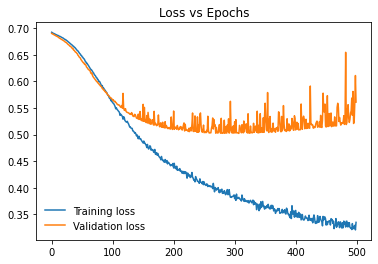

In [ ]:
plot_metrics(train_losses, valid_losses, 'loss', 1)

### **8. Métricas pedidas no exercício:**

#### **8.1. Tempo de execução de 1 laço de treinamento e o tempo médio por amostra:**

In [ ]:
model = SelfAttentionNN(embeddings=word2vec_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]']).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_loss, train_acc = train(X=X_train_ids, Y=Y_train, model=model, optimizer=optimizer, criterion=criterion)
end_time = time.time()
loop_time = end_time - start_time

print(f'Tempo de execução de 1 laço de treinamento: {loop_time*1000} ms.')
print(f'Tempo médio para processar 1 amostra: {loop_time*1000/len(X_train_ids)} ms.')

Tempo de execução de 1 laço de treinamento: 105.07774353027344 ms.
Tempo médio para processar 1 amostra: 0.1313471794128418 ms.


#### **8.2. Acurácia junto aos dados de validação após o treinamento:**

In [ ]:
print(f'Acurácia na validação: {valid_acc*100}%')

Acurácia na validação: 55.50000000000001%


#### **8.3. Número de parâmetros ajustáveis do modelo:**

In [ ]:
num_params = [params.numel() for params in list(model.parameters())]
print(f'Número de parâmetros totais (incluindo os não treináveis do word2vec: {num_params}')
num_params = np.sum(np.array(num_params[1::]))
print(f'Número de parâmetros treináveis do modelo: {num_params}')

Número de parâmetros totais (incluindo os não treináveis do word2vec: [120000300, 90000, 300, 600, 2]
Número de parâmetros treináveis do modelo: 90902


#### **8.4. Número de parâmetros ajustáveis do modelo:**

In [ ]:
print(f'Número de palavras por amostra: 64')
print(f'Embedding size: {word2vec_model.vector_size}')
print(f'Batch size de treinamento: 16')

Número de palavras por amostra: 64
Embedding size: 300
Batch size de treinamento: 16
